# Modelling Building Efficiency in NY

Data: BlocPower and Public Heating and Cooling data from 103 New York Buildings

## 1. Import Python Libraries & Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model

In [2]:
bloc_df = pd.read_csv('BlocPower_T.csv')
cdd_hdd_df = pd.read_csv('CDD-HDD-Features.csv')
hdd_df = pd.read_csv('HDD-Features.csv')
energy_loc_df = pd.read_csv('clusterEnergyLocation.csv')
sensor_data_df = pd.read_csv('CombinedSensorData.csv')
energy_loc_df = energy_loc_df[['AddressID', 'property_name', 'Address', 'Zipcode', 'Long', 'Lat', 'Annual Energy Bill (USD)']]

In [3]:
#Buidling information provided by BlocPower
bloc_df.head(1)

,UTSUM_Electricity_Usage,INFO_Year of Construction,INFO_Number of Stories,INFO_Total Square Feet,PLEI_1_Quantity,PLEI_3_Quantity
0,"117,870 kWh",1955,4,"14,600",1.0,2


In [4]:
#Buidling information provided by BlocPower
energy_loc_df.head(1)

,AddressID,property_name,Address,Zipcode,Long,Lat,Annual Energy Bill (USD)
0,125 East 105th Street10029,ChurchofStCeciliaReport,125 East 105th Street,10029,-73.947326,40.791919,"$21,216.60"


In [5]:
#Public buidling energy data 
cdd_hdd_df.head(1)

,Property Name,plug_load_consumption,ac_consumption,domestic_gas,heating_gas
0,ChurchofStCeciliaReport,11.651406,0.983531,0.096226,0.366193


## 2. Data Preparation

#### BlocPower_T.csv Transformation to df

In [6]:
#display info
bloc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 6 columns):
UTSUM_Electricity_Usage      98 non-null object
INFO_Year of Construction    100 non-null object
INFO_Number of Stories       103 non-null int64
INFO_Total Square Feet       103 non-null object
PLEI_1_Quantity              95 non-null float64
PLEI_3_Quantity              88 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 4.9+ KB


In [7]:
# column 'UTSUM_Electricity_Usage' is an object type with NaN values. 

#Removes unwanted characters
bloc_df['UTSUM_Electricity_Usage'] = bloc_df['UTSUM_Electricity_Usage'].map(lambda x: str(x)[:-4])
bloc_df['UTSUM_Electricity_Usage'].replace(regex=True,inplace=True,to_replace=r',',value=r'')

#Converts column to float type
UT = []
for i in bloc_df['UTSUM_Electricity_Usage']:
    try:
        UT.append(np.float(i))
    except:
        UT.append(np.nan)
bloc_df['UTSUM_Electricity_Usage'] = UT

#fills NaNs with mean values
mean_usage = bloc_df['UTSUM_Electricity_Usage'].mean()
bloc_df['UTSUM_Electricity_Usage'].fillna(mean_usage, inplace=True)

In [8]:
# column 'INFO_Year of Construction' is an object type with NaN values. 

#Converts column to float type
year = []
for i in bloc_df['INFO_Year of Construction']:
    try:
        year.append(np.float(i))
    except:
        year.append(np.nan)
bloc_df['INFO_Year of Construction'] = year

#Calculates Age of building
age = []
for i in bloc_df['INFO_Year of Construction']:
    try:
        age.append(2016.0-i)
    except:
        age.append(np.nan)
bloc_df['Age'] = age

#fills NaNs with mean values
mean_age = bloc_df['Age'].mean()
bloc_df['Age'].fillna(mean_age, inplace=True)

In [9]:
# column 'INFO_Total Square Feet' is an object. 

#Removes unwanted characters
bloc_df['INFO_Total Square Feet'].replace(regex=True,inplace=True,to_replace=r',',value=r'')

#Converts column to float type
sf = []
for i in bloc_df['INFO_Total Square Feet']:
    try:
        sf.append(np.float(i))
    except:
        sf.append(np.nan)
bloc_df['INFO_Total Square Feet'] = sf

In [10]:
# column 'PLEI_1_Quantity' has NaN values, interpreted as 0 plugged in electrical equipments

#fill NaNs with zeros
bloc_df['PLEI_1_Quantity'].fillna(0, inplace=True)

In [11]:
# column 'PLEI_3_Quantity' is an object type with NaN values, interpreted as 0 plugged in electrical equipments

#Converts column to float type
plei = []
for i in bloc_df['PLEI_3_Quantity']:
    try:
        plei.append(np.float(i))
    except:
        plei.append(np.nan)
bloc_df['PLEI_3_Quantity'] = plei
        
#fill NaNs with zeros
bloc_df['PLEI_3_Quantity'].fillna(0, inplace=True)

#### clusterEnergyLocation.csv Transformation to df

In [12]:
#display info
energy_loc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 7 columns):
AddressID                   103 non-null object
property_name               103 non-null object
Address                     103 non-null object
Zipcode                     103 non-null int64
Long                        103 non-null float64
Lat                         103 non-null float64
Annual Energy Bill (USD)    103 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 5.7+ KB


In [13]:
# column 'Annual Energy Bill (USD)' is an object type. 

#Removes unwanted characters
energy_loc_df['Annual Energy Bill (USD)'].replace(regex=True,inplace=True,to_replace=r'\$',value=r'')
energy_loc_df['Annual Energy Bill (USD)'].replace(regex=True,inplace=True,to_replace=r',',value=r'')

#Converts column to float type
usd = []
for i in energy_loc_df['Annual Energy Bill (USD)']:
    try:
        usd.append(np.float(i))
    except:
        usd.append(np.nan)
energy_loc_df['Annual Energy Bill (USD)'] = usd

#### CDD-HDD-Features.csv Transformation to df

In [14]:
cdd_hdd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 5 columns):
Property Name            103 non-null object
plug_load_consumption    103 non-null float64
ac_consumption           103 non-null float64
domestic_gas             103 non-null float64
heating_gas              103 non-null float64
dtypes: float64(4), object(1)
memory usage: 4.1+ KB


#### Bring all Together

In [15]:
#concatenate with cdd_hdd_df to include domestic gas and heating gas
bloc_df= pd.concat([cdd_hdd_df, bloc_df], axis=1)
bloc_df= pd.concat([bloc_df, energy_loc_df], axis =1)

#Rename Columns
bloc_df.columns = ['Property Name', 'Plug Load Consumption', 'AC Consumption','Domestic Gas', 'Heating Gas','Energy Usage', 'Year of Construction', 'Number of Stories', 'Square Feet', 'PLEI_1', 'PLEI_3', 'Age', 'Address ID', 'property_name', 'Address', 'Zipcode', 'Longitude', 'Latitude', 'Annual Energy Bill (USD)' ]
bloc_df = bloc_df[['Property Name', 'Energy Usage', 'Age', 'Number of Stories', 'Square Feet', 'PLEI_1', 'PLEI_3', 'Domestic Gas', 'Heating Gas', 'Plug Load Consumption', 'AC Consumption', 'Annual Energy Bill (USD)', 'Year of Construction', 'Address ID', 'Address', 'Zipcode', 'Longitude', 'Latitude']]

In [16]:
bloc_df.head(1)

,Property Name,Energy Usage,Age,Number of Stories,Square Feet,PLEI_1,PLEI_3,Domestic Gas,Heating Gas,Plug Load Consumption,AC Consumption,Annual Energy Bill (USD),Year of Construction,Address ID,Address,Zipcode,Longitude,Latitude
0,ChurchofStCeciliaReport,117870.0,61.0,4,14600.0,1.0,2.0,0.096226,0.366193,11.651406,0.983531,21216.6,1955.0,125 East 105th Street10029,125 East 105th Street,10029,-73.947326,40.791919


In [17]:
#display info after data cleaned
bloc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 18 columns):
Property Name               103 non-null object
Energy Usage                103 non-null float64
Age                         103 non-null float64
Number of Stories           103 non-null int64
Square Feet                 103 non-null float64
PLEI_1                      103 non-null float64
PLEI_3                      103 non-null float64
Domestic Gas                103 non-null float64
Heating Gas                 103 non-null float64
Plug Load Consumption       103 non-null float64
AC Consumption              103 non-null float64
Annual Energy Bill (USD)    103 non-null float64
Year of Construction        96 non-null float64
Address ID                  103 non-null object
Address                     103 non-null object
Zipcode                     103 non-null int64
Longitude                   103 non-null float64
Latitude                    103 non-null float64
dtypes: float64(13), 

## 3. Exploratory Analysis

C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  


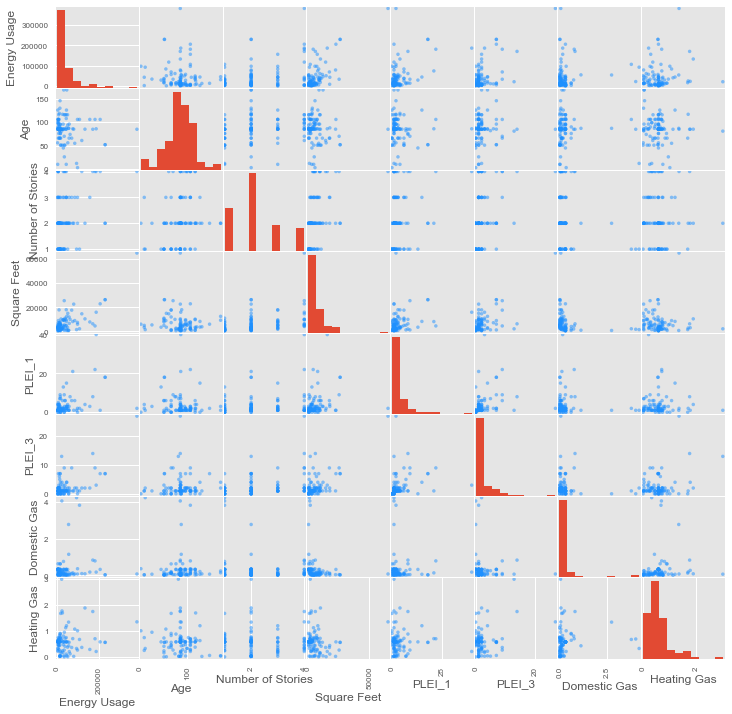

In [18]:
#Show correlation matrix
plt.style.use('ggplot')
correlations = pd.tools.plotting.scatter_matrix(bloc_df[['Property Name', 'Energy Usage', 'Age', 
                                                         'Number of Stories', 'Square Feet', 'PLEI_1', 
                                                         'PLEI_3', 'Domestic Gas', 'Heating Gas']], 
                                                diagonal='hist',figsize=(12,12), color='#1e90ff')

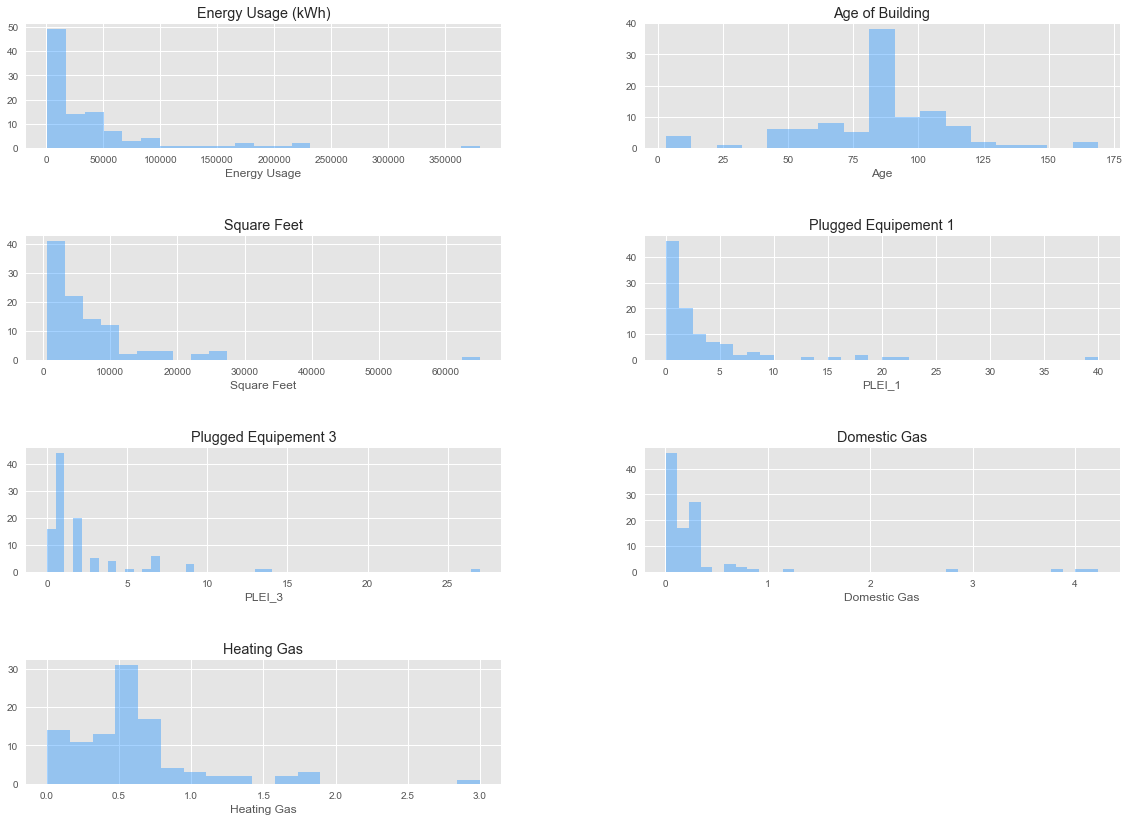

In [19]:
#Plot Histograms of Parameters

a =plt.subplot(421)
sns.distplot(bloc_df["Energy Usage"], color='#1e90ff', kde=False)
a.set_title("Energy Usage (kWh)")

b =plt.subplot(422)
sns.distplot(bloc_df['Age'], color='#1e90ff', kde=False)
b.set_title("Age of Building")

c =plt.subplot(423)
sns.distplot(bloc_df['Square Feet'], color='#1e90ff', kde=False)
c.set_title("Square Feet")

d =plt.subplot(424)
sns.distplot(bloc_df['PLEI_1'], color='#1e90ff', kde=False)
d.set_title("Plugged Equipement 1")

e =plt.subplot(425)
sns.distplot(bloc_df['PLEI_3'], color='#1e90ff', kde=False)
e.set_title("Plugged Equipement 3")

f =plt.subplot(426)
sns.distplot(bloc_df['Domestic Gas'], color='#1e90ff', kde=False)
f.set_title("Domestic Gas")

g =plt.subplot(427)
sns.distplot(bloc_df['Heating Gas'], color='#1e90ff', kde=False)
g.set_title("Heating Gas")

plt.subplots_adjust(top=2, bottom=0.08, left=0.10, right=2, hspace=.7, wspace=0.3)
plt.show()

## 4. Regression Analysis

In [20]:
from sklearn import preprocessing
regr_df = bloc_df[['Energy Usage', 'Age', 'Number of Stories', 'Square Feet', 'PLEI_1', 'PLEI_3', 'Domestic Gas', 'Heating Gas']]
scaler = preprocessing.MaxAbsScaler() 
feat = scaler.fit_transform(regr_df)
cols = regr_df.columns

# define a new dataframe with the scaled data
dfScaled = pd.DataFrame(feat,columns=cols)

# get a list of the features used to explain energy
features = dfScaled.columns.tolist()
features.remove('Energy Usage')

# declare a linear regression model 
lr = linear_model.LinearRegression(fit_intercept=True)

# define independent variable
y = np.array(dfScaled['Energy Usage']) 

# define features
x = dfScaled[features]

# fit regression model to the data
regression = lr.fit(x,y)
coefficient = regression.coef_

# collect regression coefficients
dataRegQ = []
dataRegQ.append(('Intercept', regression.intercept_))
for i in range(len(features)):
    dataRegQ.append((features[i],coefficient[i]))

# compute energy predictions using our fitted model     
yh = regression.predict(x)

# import package to compute the R-squared quality metric
from sklearn.metrics import r2_score
# print results
print ('R-Squared: ', r2_score(y,yh))
pd.DataFrame(dataRegQ,columns=['feature_name','coefficient'])

R-Squared:  0.71750454564


,feature_name,coefficient
0,Intercept,-0.067143
1,Age,-0.023500
2,Number of Stories,0.048774
3,Square Feet,0.777122
4,PLEI_1,0.312308
5,PLEI_3,0.122954
6,Domestic Gas,0.229171
7,Heating Gas,0.143661


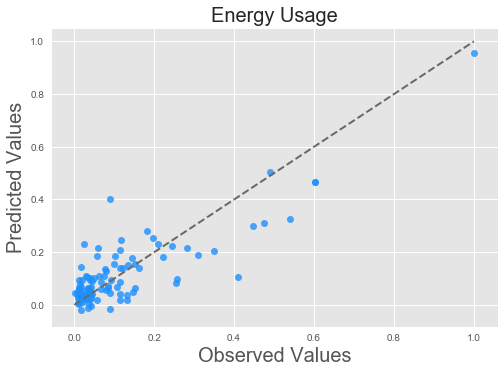

In [21]:
#Plot dashed line to represent perfect model
x1=[0,1]
y1=[0,1]
plt.plot(x1, y1, linewidth=2.0, linestyle='dashed', color='#696969')

#plot observed vs. predicted values
sns.regplot(y,yh, fit_reg=False, color = '#1e90ff')
plt.xlabel('Observed Values', fontsize=20)
plt.ylabel('Predicted Values', fontsize=20)
plt.title('Energy Usage', fontsize=20)

## 5. Labelling Inefficient Buildings

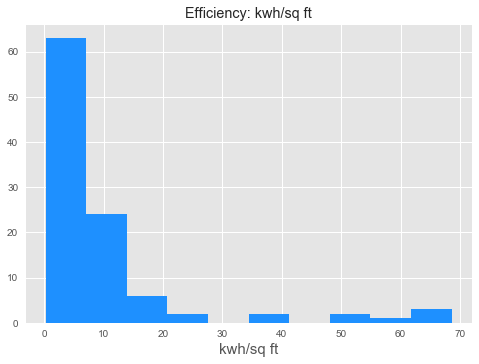

In [22]:
#calculate kwh/sq ft and add to data frame
bloc_df['kwh/sq ft'] = bloc_df['Energy Usage']/bloc_df['Square Feet']

#plot histogram of kwh/sq ft
plt.hist(bloc_df['kwh/sq ft'], color = '#1e90ff')
plt.title('Efficiency: kwh/sq ft')
plt.xlabel('kwh/sq ft', fontsize=15)

In [23]:
#Buildings with kwh/sq ft>20 will be lables as Inefficient with a True value
bloc_df['Inefficient'] = bloc_df['kwh/sq ft']>20

## 6. Modelling: Unsupervised Learning

#### Kmeans using all parameters

In [24]:
#Using all parameters
kmeans_df1 = bloc_df.copy(deep=True)
del kmeans_df1['Inefficient']
del kmeans_df1['Property Name']
del kmeans_df1['Year of Construction']
del kmeans_df1['Address ID']
del kmeans_df1['Address']
del kmeans_df1['Zipcode']
del kmeans_df1['Longitude']
del kmeans_df1['Latitude']
del kmeans_df1['kwh/sq ft']

k = 2


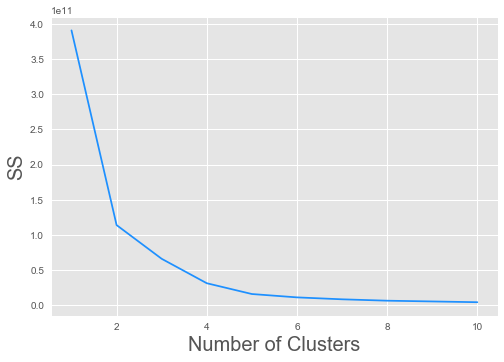

In [25]:
#Choosing K-clusters: elbow method
import scipy
from sklearn.cluster import KMeans

#Create numpy matrix x_cols
x_cols = kmeans_df1.as_matrix()

#Construct plot showing SS for each K
x =list(range(1,11))
y =[]
for k in range(1,11):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(x_cols)
    y.append(kmeans.inertia_)
plt.plot(x,y, color ='#1e90ff')
plt.ylabel("SS", fontsize=20)
plt.xlabel("Number of Clusters", fontsize=20)
print('k = 2')

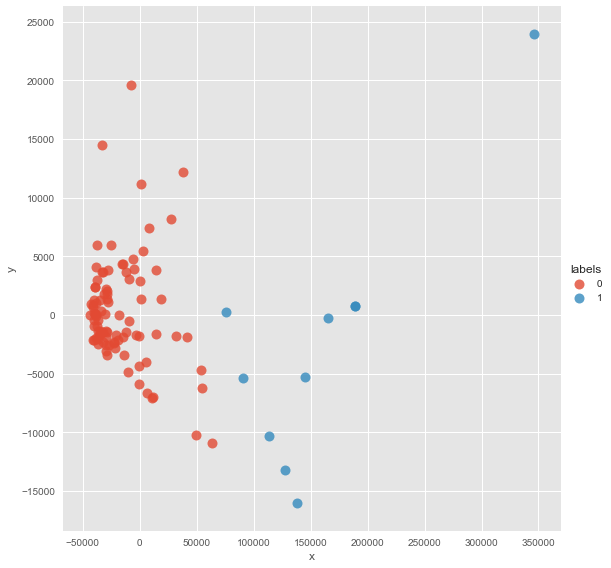

In [26]:
#visualize clusters using PCA method
import sklearn
kmeans = KMeans(n_clusters = 2)
kmeans.fit(x_cols)
labels = kmeans.labels_

#create data frame with only two components
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(kmeans_df1)
df_pca = pd.DataFrame(pca.transform(kmeans_df1))
df_pca.index = kmeans_df1.index
df_pca['labels'] = labels
df_pca.columns = ['x', 'y', 'labels']

#Plot scatter 
sns.lmplot(data=df_pca, x='x', y='y', hue='labels', size=8, fit_reg=False,scatter_kws={'s':100})

In [27]:
#Accuracy of model
(len(bloc_df)-sum(abs(bloc_df['Inefficient']-labels)))/len(bloc_df)

0.84466019417475724

#### Kmeans using energy parameters

In [28]:
#Create dataframe with dimension used to measure energy inefficiencies scaled by dividing building square footage
bloc_df['Square Feet'] = sf
d1 = bloc_df['Domestic Gas']/sf
d2 = bloc_df['Heating Gas']/sf
d3 = bloc_df['Plug Load Consumption']/sf
d4 = bloc_df['AC Consumption']/sf
columns = ['Domestic Gas', 'Heating Gas', 'Plug Load Consumption', 'AC Consumption']
kmeans_df2 = pd.DataFrame(columns=columns)
kmeans_df2['Domestic Gas'] = d1
kmeans_df2['Heating Gas'] = d2
kmeans_df2['Plug Load Consumption'] = d3
kmeans_df2['AC Consumption'] = d4

k = 2


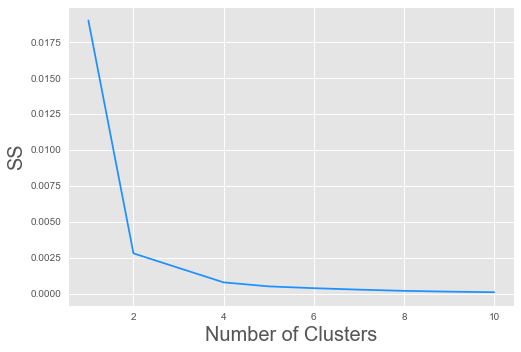

In [29]:
#Choosing K-clusters: elbow method
import scipy
from sklearn.cluster import KMeans

#Create numpy matrix x_cols
x_cols = kmeans_df2.as_matrix()

#Construct plot showing SS for each K
x =list(range(1,11))
y =[]
for k in range(1,11):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(x_cols)
    y.append(kmeans.inertia_)
plt.plot(x,y, color ='#1e90ff')
plt.ylabel("SS", fontsize=20)
plt.xlabel("Number of Clusters", fontsize=20)
print('k = 2')

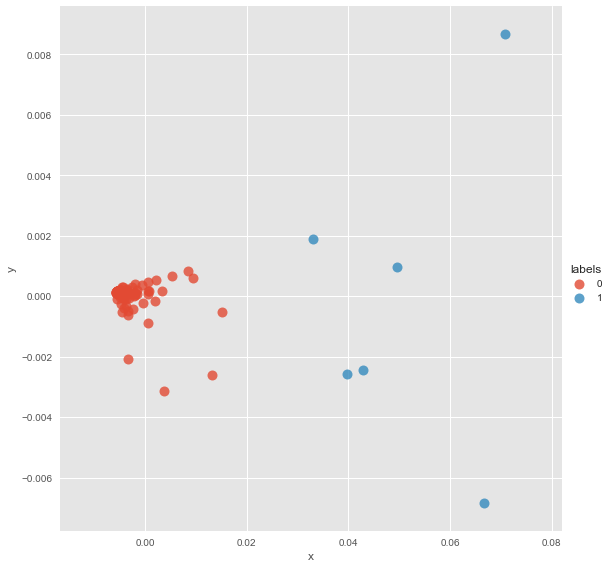

In [30]:
#visualize clusters using PCA method
import sklearn
kmeans = KMeans(n_clusters = 2)
kmeans.fit(x_cols)
labels = kmeans.labels_

#create data frame with only two components
pca = sklearn.decomposition.PCA(n_components=2)
pca.fit(kmeans_df2)
df_pca = pd.DataFrame(pca.transform(kmeans_df2))
df_pca.index = kmeans_df2.index
df_pca['labels'] = labels
df_pca.columns = ['x', 'y', 'labels']

#Plot scatter 
sns.lmplot(data=df_pca, x='x', y='y', hue='labels', size=8, fit_reg=False,scatter_kws={'s':100})

In [31]:
#Accuracy of model
sum(abs(bloc_df['Inefficient']-labels))/len(bloc_df)

0.038834951456310676

# 7. Modelling: Supervised Learning

#### Random Forrest Classifier using all parameters

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.datasets import load_iris

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [33]:
# separate parameters and labels
df_x = bloc_df.iloc[:,1:11]
df_y = bloc_df.iloc[:,19]

In [34]:
#split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=.2, random_state=4)

In [35]:
#Run Random Forrest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [36]:
#Calculate predictions based testing data
predictions = rf.predict(x_test)

In [37]:
#Model Accuracy
count = 0
for i in range(len(predictions)):
    if predictions[i]==y_test.values[i]:
        count+=1
count/len(predictions)

1.0

Feature ranking:
1. feature 8 (0.349191)
2. feature 9 (0.255619)
3. feature 6 (0.098710)
4. feature 0 (0.062940)
5. feature 3 (0.058034)
6. feature 1 (0.048525)
7. feature 5 (0.038545)
8. feature 2 (0.034186)
9. feature 4 (0.030075)
10. feature 7 (0.024176)


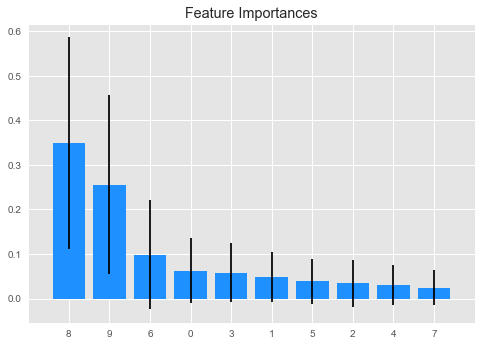

In [38]:
#Plot Feature Importances

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a classification task using informative features
X, y = x_train, y_train

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="#1e90ff", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [39]:
x_train.head(1)

,Energy Usage,Age,Number of Stories,Square Feet,PLEI_1,PLEI_3,Domestic Gas,Heating Gas,Plug Load Consumption,AC Consumption
86,54860.0,87.0,2,800.0,1.0,0.0,2.767528,1.341849,56.222162,14.778739
